In [1]:
from skilift import GTFS, get_stop_node, read_osm, get_elevations_for_nodes, get_graph_nodes, ElevationAwareStreetDataset

In [2]:
import pandas as pd
from zipfile import ZipFile
from collections import defaultdict
from typing import Dict, Set, Tuple, Iterable, Iterator, Any
import numpy as np
from shapely.geometry import Point, LineString, MultiLineString
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
fn = "/home/bmander/skilift_data/transit/redding.zip"

feed = GTFS(fn)

In [4]:
# get epoch time on Aptil 19, 2023 at 1:00pm pacific time
t0 = pd.Timestamp("2023-04-19 13:00:00", tz="America/Los_Angeles")
t0

Timestamp('2023-04-19 13:00:00-0700', tz='America/Los_Angeles')

In [5]:
node0 = get_stop_node(feed, "Downtown Transit Center", t0)
node0

AtStopNode(stop_id:2000, datetime:2023-04-19 13:00:00-07:00)

In [6]:
node0.outgoing[0].node

DepartureNode(pattern_id:5, service_id:c_1658_b_18260_d_31, row:1, col:0, datetime:2023-04-19 14:25:00-07:00)

In [7]:
node0.outgoing[0].node.outgoing[0].node

ArrivalNode(pattern_id:5, service_id:c_1658_b_18260_d_31, row:1, col:1, datetime:2023-04-19 14:35:00-07:00)

In [8]:
node0.outgoing[0].node.outgoing[0].node.outgoing

[Edge(node=DepartureNode(pattern_id:5, service_id:c_1658_b_18260_d_31, row:1, col:1, datetime:2023-04-19 14:35:00-07:00), weight=0.0),
 Edge(node=AtStopNode(stop_id:8003, datetime:2023-04-19 14:35:00-07:00), weight=60.0)]

In [9]:
osm_filename = "/home/bmander/skilift_data/street/redding.pbf"


In [10]:
elev_geotiff_filename = "/home/bmander/skilift_data/elevation/USGS_13_n41w123_20210624.tif"

In [11]:
elev_dataset = ElevationAwareStreetDataset(osm_filename, elev_geotiff_filename)

Reading OSM file...done
Indexing ways...done
Getting node elevations...done
Creating spatial index...done


In [12]:
def geodesic_distance_meters(geo_pt: Point, geo_pt2: Point) -> float:
    """Compute the geodesic distance in meters between two points on the earth's surface.
    """

    # TODO: this can be vectorized if it ever becomes a bottleneck

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [geo_pt.x, geo_pt.y, geo_pt2.x, geo_pt2.y])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    earth_radius_km = 6371
    km = earth_radius_km * c
    return km * 1000

In [13]:
nd_points = elev_dataset.nodes.values()
lon = sum([x[0] for x in nd_points])/len(nd_points)
lat = sum([x[1] for x in nd_points])/len(nd_points)
lon, lat

(40.58422925237579, -122.35866061888524)

In [14]:
segment_ids = elev_dataset.segment_spatial_index.query(Point(lon, lat).buffer(0.001))
segment_ids

array([   519,   2083,   2084,   2085,   2086,  57604,  57603,  57602,
       167757, 167756, 157096, 193210, 193405, 193219, 193404,   2087,
         2088,   2089, 167761, 120341,  57584, 187726,  57585,  57586,
        57587,  57591,  57592,  57601,  57593,  57600,  57613,  57612,
        57611,  57610,  57609,  57608,  57607,  57606,  57605,  57588,
        57589,  57590, 187727,  57594,  57599,  57598,  57595,  57597,
        57596,    520,    521,    522,    523,  62078,  62079,  62080,
       112847, 143373, 143372, 112896, 172506, 157098,  58881, 112848,
       112844, 167758, 167759, 167760, 193208, 193209, 193407, 193406,
        62448, 157097, 193211])

33.32896864818154


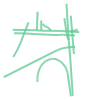

In [15]:
segments = [elev_dataset.segments[segment_id] for segment_id in segment_ids]
# combine all segments into multigeometry
ls = MultiLineString(segments)
print(geodesic_distance_meters(ls.centroid, Point(lon, lat)))
ls

In [16]:
query_pt = Point(lon, lat)
segment_distances = [segment.distance(query_pt) for segment in segments]
closest_ix = np.argmin( segment_distances )

print( segment_distances[closest_ix], segments[closest_ix] )

0.00015369620164789116 LINESTRING (40.5842158 -122.3588395, 40.5846572 -122.3586171)


In [17]:
elev_dataset.segment_way_refs[segment_ids[closest_ix]]

(10557590, 13)

In [18]:
linear_ref = segments[closest_ix].line_locate_point(query_pt, normalized=True)

In [19]:
closest_point = segments[closest_ix].interpolate(linear_ref)

In [20]:
geodesic_distance_meters(closest_point, query_pt)

25.92427198355799

In [21]:
way_id, seg_ix, linear_ref = elev_dataset.get_nearest_segment(lat, lon)
way_id, seg_ix, linear_ref

(10557590, 13, 0.18715448062975482)

In [22]:
seg = LineString([elev_dataset.nodes[node_id] for node_id in elev_dataset.ways[way_id].nds[seg_ix:seg_ix+2]])
nearest_point = seg.line_interpolate_point(linear_ref, normalized=True)

In [23]:
geodesic_distance_meters(Point(lon, lat), nearest_point)

15.80760752260572

In [17]:
for nd_ix in tree.query(avg.buffer(0.0003)):
    pt = nd_points[nd_ix]

    # find distance in meters between geographical points
    dist = geodesic_distance_meters(avg, pt)
    print(dist)

33.586155638010396
30.45918994893321
30.448305567346534
30.984222752860745
19.906777976196068


In [18]:
def cons(ary: Iterable) -> Iterator[Tuple[Any, Any]]:
    """Return a generator of consecutive pairs from the input iterable."""
    it = iter(ary)
    prev = next(it)
    for item in it:
        yield prev, item
        prev = item

way_segments = []
for way_id, way in elev_dataset.ways.items():
    for segment_ix, (nd1, nd2) in enumerate(cons(way.nds)):
        pt1 = elev_dataset.nodes[nd1]
        pt2 = elev_dataset.nodes[nd2]

        segment = LineString([pt1, pt2])

        way_segments.append( (way_id, segment_ix, segment) )


In [19]:
way_segments_index = STRtree([seg[2] for seg in way_segments])

In [20]:
dists = []

for ix in way_segments_index.query(avg.buffer(0.0003)):
    way_id, i, segment = way_segments[ix]

    way_segment_dist = segment.distance(avg)

    dists.append( (ix, way_segment_dist) )

closest_ix = min( dists, key=lambda x: x[1] )[0]

way_id, i, segment = way_segments[closest_ix]
linear_ref = segment.line_locate_point(avg, normalized=True)
print(way_id, i, linear_ref)


10557590 13 0.18715448062975482
